HRM Training Process

load sudoku data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import os
import pydantic 

from typing import Optional

from dataset.sudoku import SudokuDataset

from typing import Tuple, List, Dict, Optional

import dataset.sudoku as sudoku

def load_sudoku_data(data_path: str, max_samples: int = 2000):
    # Load the dictionary that was saved
    data = np.load(data_path, allow_pickle=True).item()
 
    puzzles = []
    solutions = []

    # Extract puzzles and solutions from the dictionary
    for i in range(min(max_samples, len(data))):
        if i in data:
            puzzles.append(data[i]["puzzle"])
            solutions.append(data[i]["solution"])

    return np.array(puzzles), np.array(solutions)

# presenting the data
puzzles, solutions = load_sudoku_data("./data/sudoku_train.npy")
test_puzzles, test_solutions = load_sudoku_data("./data/sudoku_test.npy")

print(test_puzzles.shape)
print(test_solutions.shape)

sudoku.display_puzzle_pair(puzzles[0].reshape(9, 9), solutions[0].reshape(9, 9))

(2000, 81)
(2000, 81)

INPUT (_ = blank)        SOLUTION
  0 1 2 3 4 5 6 7 8      0 1 2 3 4 5 6 7 8
  -----------------      -----------------
0| _ _ 9 5 1 _ 7 3 _    0| 2 6 9 5 1 4 7 3 8
1| _ _ _ 2 _ 3 _ 5 _    1| 1 7 4 2 8 3 6 5 9
2| _ 3 _ _ 9 _ _ _ 2    2| 8 3 5 7 9 6 4 1 2
3| 3 1 _ _ _ _ _ _ _    3| 3 1 8 9 7 2 5 4 6
4| _ _ _ _ _ _ 2 _ _    4| 6 5 7 3 4 8 2 9 1
5| 4 _ _ _ _ _ _ _ _    5| 4 9 2 6 5 1 8 7 3
6| _ _ _ 8 6 _ _ _ 5    6| 9 4 3 8 6 7 1 2 5
7| _ _ _ 4 2 _ 3 6 _    7| 5 8 1 4 2 9 3 6 7
8| 7 _ _ _ _ _ _ 8 4    8| 7 2 6 1 3 5 9 8 4

Statistics: 25 filled, 56 blank cells


In [2]:
from hrm import HRMConfig, HierarchicalReasoningModel, ModelConfig

class HRMTrainer:
    """
    Trainer class for the Hierarchical Reasoning Model.
    
    """
    
    def __init__(self, 
                 model: HierarchicalReasoningModel, 
                 config=None, device=None):
        
        self.model = model
        self.config = config or ModelConfig()
        self.device = device or torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

        self.model.to(self.device)
        
        # Training components
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(
            list(self.model.parameters()),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5
        )
        
        # Training state
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')
        self.best_model_state = None
        self.epochs_without_improvement = 0
        
        # Early stopping params
        self.patience = 15
        
        # Create results directory
        os.makedirs('results', exist_ok=True)

    def _accuracy(self, logits: torch.Tensor, targets: torch.Tensor) -> float:
        # logits: (B, 81, C) targets: (B,81)
        print(logits.shape, targets.shape)
        preds = logits.argmax(dim=-1)
        correct = (preds == targets).float().sum().item()
        total = targets.numel()
        return correct / total

    # Replace your _run_epoch method with this corrected version
    def _run_epoch(self, loader: DataLoader, train: bool = True):
        
        if train:
            self.model.train()
        else:
            self.model.eval()
        
        epoch_loss = 0.0
        epoch_acc = 0.0
        total_batches = 0
        
        for batch in loader:
            puzzles, solutions = batch["puzzle"], batch["solution"]
            puzzles = puzzles.to(self.device).float()
            solutions = solutions.to(self.device).long()
            
            # Debug shapes at each step
            #print(f"Batch {total_batches}: Input {puzzles.shape}, Target {solutions.shape}")
            
            if train:
                self.optimizer.zero_grad()

            # Forward pass - add unsqueeze to make input 3D
            if puzzles.dim() == 2:
                puzzles = puzzles.unsqueeze(-1)  # (B, 81) -> (B, 81, 1)
            
            model_output = self.model(puzzles)
            #print(f"Model output shape: {model_output.shape}")

            
            # Calculate loss based on output dimensions
            batch_size, seq_len, num_classes = model_output.shape

            output_flat = model_output.view(-1, num_classes)  # (B*81, C)
            solutions_flat = solutions.view(-1)               # (B*81,)
            #print(f"  Flattened: output {output_flat.shape}, target {solutions_flat.shape}")
            
            loss = self.criterion(output_flat, solutions_flat)
            
            # FIX: Compare flattened predictions with flattened solutions
            preds = output_flat.argmax(dim=-1)  # (B*81,)
            acc = (preds == solutions_flat).float().mean().item()  # Both same shape now

            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc
            total_batches += 1
                
        return epoch_loss / max(1, total_batches), epoch_acc / max(1, total_batches)

    def train(self, train_dataset, val_dataset=None):
        epochs = self.config.max_epochs
        train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.config.batch_size) if val_dataset is not None else None

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = self._run_epoch(train_loader, train=True)
            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc)

            if val_loader is not None:
                with torch.no_grad():
                    val_loss, val_acc = self._run_epoch(val_loader, train=False)
                self.val_losses.append(val_loss)
                self.val_accuracies.append(val_acc)
                self.scheduler.step(val_loss)
            else:
                val_loss, val_acc = train_loss, train_acc  # fallback

            improved = val_loss < self.best_val_loss - 1e-5
            if improved:
                self.best_val_loss = val_loss
                self.best_model_state = {
                    'model': self.model.state_dict(),
                    'epoch': epoch,
                    'val_loss': val_loss
                }
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

            print(f"Epoch {epoch:03d} | Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f} | LR {self.optimizer.param_groups[0]['lr']:.2e}")

            if self.epochs_without_improvement >= self.patience:
                print("Early stopping triggered.")
                break

        # Save best checkpoint
        if self.best_model_state is not None:
            torch.save(self.best_model_state, 'results/best_model.pt')
            print(f"Best model (val_loss={self.best_model_state['val_loss']:.4f}) saved to results/best_model.pt")

    def evaluate(self, dataset):
        loader = DataLoader(dataset, batch_size=self.config.batch_size)
        with torch.no_grad():
            loss, acc = self._run_epoch(loader, train=False)
        print(f"Eval Loss {loss:.4f} Acc {acc:.4f}")
        return loss, acc

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

hrm_config = HRMConfig(
    input_dim=1,   # Each position has 1 feature (digit value) - input is (B, 81, 1)
    output_dim=10, # 10 possible values (0-9) for each position
    hidden_dim=512, # Reasonable hidden size
    num_layers=4,
    dropout=0.1,
    N=2,  # Number of high-level cycles
    T=4   # Number of low-level cycles per high-level cycle
)

model_config = ModelConfig(
    learning_rate=0.001,
    batch_size=32,
    max_epochs=30,
    embeddings_lr=0.001,
    weight_decay=1e-4  # Much smaller weight decay
)

model = HierarchicalReasoningModel(config=hrm_config, device=device)

trainer = HRMTrainer(model, config=model_config, device=device)

train_dataset = sudoku.SudokuDataset(puzzles, solutions)
val_dataset = sudoku.SudokuDataset(test_puzzles, test_solutions)

trainer.train(train_dataset, val_dataset=val_dataset)

Epoch 001 | Train Loss 1.9805 Acc 0.2791 | Val Loss 1.7341 Acc 0.3173 | LR 1.00e-03
Epoch 002 | Train Loss 1.6835 Acc 0.3696 | Val Loss 1.6160 Acc 0.3859 | LR 1.00e-03
Epoch 003 | Train Loss 1.5987 Acc 0.3844 | Val Loss 1.5879 Acc 0.3852 | LR 1.00e-03
Epoch 004 | Train Loss 1.5555 Acc 0.3845 | Val Loss 1.5431 Acc 0.3853 | LR 1.00e-03
Epoch 005 | Train Loss 1.5606 Acc 0.3845 | Val Loss 1.5417 Acc 0.3849 | LR 1.00e-03
Epoch 006 | Train Loss 1.6026 Acc 0.3770 | Val Loss 1.5755 Acc 0.3864 | LR 1.00e-03
Epoch 007 | Train Loss 1.5602 Acc 0.3855 | Val Loss 1.5530 Acc 0.3862 | LR 1.00e-03
Epoch 008 | Train Loss 1.5346 Acc 0.3857 | Val Loss 1.5257 Acc 0.3852 | LR 1.00e-03
Epoch 009 | Train Loss 1.5294 Acc 0.3848 | Val Loss 1.5391 Acc 0.3859 | LR 1.00e-03
Epoch 010 | Train Loss 1.5737 Acc 0.3747 | Val Loss 1.5579 Acc 0.3852 | LR 1.00e-03
Epoch 011 | Train Loss 1.6434 Acc 0.3417 | Val Loss 1.7031 Acc 0.2801 | LR 1.00e-03
Epoch 012 | Train Loss 2.0633 Acc 0.2363 | Val Loss 1.7172 Acc 0.3860 | LR 1

In [6]:
# Minimal test
import torch
import torch.nn as nn

# Test basic tensor operation
test_tensor = torch.zeros(1, 81)
print(f"Test tensor shape: {test_tensor.shape}")
print(f"Test tensor unsqueezed: {test_tensor.unsqueeze(-1).shape}")

# Import the HRM module and check for issues
try:
    from hrm import HRMConfig, HierarchicalReasoningModel
    print("HRM import successful")
    
    # Create config - match the main training config
    config = HRMConfig(
        input_dim=1,      # Feature dimension per cell
        output_dim=10,    # Number of classes (0-9)
        hidden_dim=128,   # Hidden dimension
        N=2, T=4          # Hierarchical parameters
    )
    print(f"Config created: input_dim={config.input_dim}, output_dim={config.output_dim}")
    
    # Create model
    device = torch.device('cpu')  # Use CPU for simplicity
    model = HierarchicalReasoningModel(config=config, device=device)
    print("Model created successfully")
    
    # Test model forward with 2D input (will be converted to 3D internally)
    test_input = torch.zeros(1, 81, dtype=torch.float32)
    print(f"Test input shape: {test_input.shape}")
    
    with torch.no_grad():
        output = model(test_input)
        print(f"Model output shape: {output.shape}")
        print(f"Expected shape: (1, 81, 10)")
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

Test tensor shape: torch.Size([1, 81])
Test tensor unsqueezed: torch.Size([1, 81, 1])
HRM import successful
Config created: input_dim=1, output_dim=10
Model created successfully
Test input shape: torch.Size([1, 81])
Model output shape: torch.Size([1, 81, 10])
Expected shape: (1, 81, 10)


In [7]:
def validate_sudoku_predictions(model, dataset, num_samples=10):
    """
    Validate that the model's predictions form valid Sudoku solutions.
    
    Args:
        model: Trained HRM model
        dataset: SudokuDataset to validate on
        num_samples: Number of samples to validate
    
    Returns:
        dict: Validation results including accuracy metrics
    """
    model.eval()
    
    def is_valid_sudoku(grid):
        """Check if a 9x9 sudoku grid is valid"""
        # Check rows
        for row in grid:
            if len(set(row)) != 9 or not all(1 <= x <= 9 for x in row):
                return False
        
        # Check columns
        for col in range(9):
            column = [grid[row][col] for row in range(9)]
            if len(set(column)) != 9:
                return False
        
        # Check 3x3 boxes
        for box_row in range(3):
            for box_col in range(3):
                box = []
                for r in range(3):
                    for c in range(3):
                        box.append(grid[box_row*3 + r][box_col*3 + c])
                if len(set(box)) != 9:
                    return False
        
        return True
    
    def calculate_cell_accuracy(predicted, target):
        """Calculate per-cell accuracy"""
        return (predicted == target).float().mean().item()
    
    # Sample validation data
    loader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    results = {
        'valid_sudokus': 0,
        'total_samples': 0,
        'cell_accuracies': [],
        'sudoku_validity_rate': 0.0,
        'average_cell_accuracy': 0.0
    }
    
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i >= num_samples:
                break
                
            puzzle, solution = batch["puzzle"], batch["solution"]
            puzzle = puzzle.to(device).float()
            solution = solution.to(device).long()
            
            # Get model prediction
            if puzzle.dim() == 2:
                puzzle = puzzle.unsqueeze(-1)  # Add feature dimension
            
            output = model(puzzle)  # Shape: (1, 81, 10)
            predicted = output.argmax(dim=-1)  # Shape: (1, 81)
            
            # Convert to numpy and reshape to 9x9
            pred_grid = predicted.cpu().numpy()[0].reshape(9, 9)
            true_grid = solution.cpu().numpy()[0].reshape(9, 9)
            
            # Calculate cell accuracy
            cell_acc = calculate_cell_accuracy(predicted[0], solution[0])
            results['cell_accuracies'].append(cell_acc)
            
            # Check if prediction is valid sudoku
            is_valid = is_valid_sudoku(pred_grid)
            if is_valid:
                results['valid_sudokus'] += 1
            
            results['total_samples'] += 1
            
            # Print first few examples
            if i < 3:
                print(f"\nSample {i+1}:")
                print("Puzzle:")
                puzzle_display = puzzle.cpu().numpy()[0].reshape(9, 9)
                for row in puzzle_display:
                    print([int(x) for x in row])
                
                print("Predicted Solution:")
                for row in pred_grid:
                    print(list(row))
                
                print("True Solution:")
                for row in true_grid:
                    print(list(row))
                
                print(f"Cell Accuracy: {cell_acc:.4f}")
                print(f"Valid Sudoku: {is_valid}")
    
    # Calculate final metrics
    results['sudoku_validity_rate'] = results['valid_sudokus'] / results['total_samples']
    results['average_cell_accuracy'] = sum(results['cell_accuracies']) / len(results['cell_accuracies'])
    
    print(f"\n=== Sudoku Validation Results ===")
    print(f"Total samples validated: {results['total_samples']}")
    print(f"Valid Sudoku solutions: {results['valid_sudokus']}")
    print(f"Sudoku validity rate: {results['sudoku_validity_rate']:.4f} ({results['sudoku_validity_rate']*100:.2f}%)")
    print(f"Average cell accuracy: {results['average_cell_accuracy']:.4f} ({results['average_cell_accuracy']*100:.2f}%)")
    
    return results

# Run validation
validation_results = validate_sudoku_predictions(model, val_dataset, num_samples=10)


Sample 1:
Puzzle:
[0, 0, 0, 0, 0, 6, 4, 7, 0]
[0, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 7, 0, 0, 0, 0, 0, 6, 1]
[0, 0, 9, 0, 0, 5, 0, 1, 7]
[0, 8, 0, 0, 0, 0, 0, 9, 0]
[3, 5, 0, 0, 1, 0, 0, 8, 0]
[9, 1, 0, 0, 0, 8, 0, 0, 0]
[7, 6, 4, 9, 0, 0, 0, 5, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
Predicted Solution:
[np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(8), np.int64(9), np.int64(8), np.int64(4)]
[np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4)]
[np.int64(4), np.int64(8), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(8), np.int64(4)]
[np.int64(4), np.int64(4), np.int64(8), np.int64(4), np.int64(4), np.int64(8), np.int64(4), np.int64(4), np.int64(8)]
[np.int64(4), np.int64(8), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(8), np.int64(4)]
[np.int64(9), np.int64(8), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(8), np.int64(4)]
[

Loaded best model from epoch 8 with val_loss 1.5257

=== Comprehensive Model Evaluation on 100 Test Games ===
Eval Loss 1.5535 Acc 0.3832

Sample 1:
Puzzle:
[4, 0, 0, 0, 0, 0, 1, 3, 7]
[0, 0, 0, 7, 0, 0, 0, 8, 0]
[1, 0, 0, 9, 0, 0, 5, 0, 0]
[0, 0, 0, 0, 0, 0, 4, 7, 0]
[8, 0, 0, 6, 0, 0, 0, 5, 0]
[0, 0, 0, 0, 0, 4, 0, 0, 0]
[0, 0, 0, 8, 1, 0, 0, 2, 0]
[0, 1, 0, 3, 7, 0, 0, 0, 5]
[6, 0, 7, 0, 0, 0, 0, 9, 0]
Predicted Solution:
[np.int64(9), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(9), np.int64(9), np.int64(9)]
[np.int64(4), np.int64(4), np.int64(4), np.int64(9), np.int64(4), np.int64(4), np.int64(4), np.int64(9), np.int64(4)]
[np.int64(9), np.int64(4), np.int64(4), np.int64(9), np.int64(4), np.int64(4), np.int64(9), np.int64(4), np.int64(4)]
[np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(9), np.int64(9), np.int64(4)]
[np.int64(9), np.int64(4), np.int64(4), np.int64(9), np.int64(4), np.int64(4), np.int64(4), np.int6

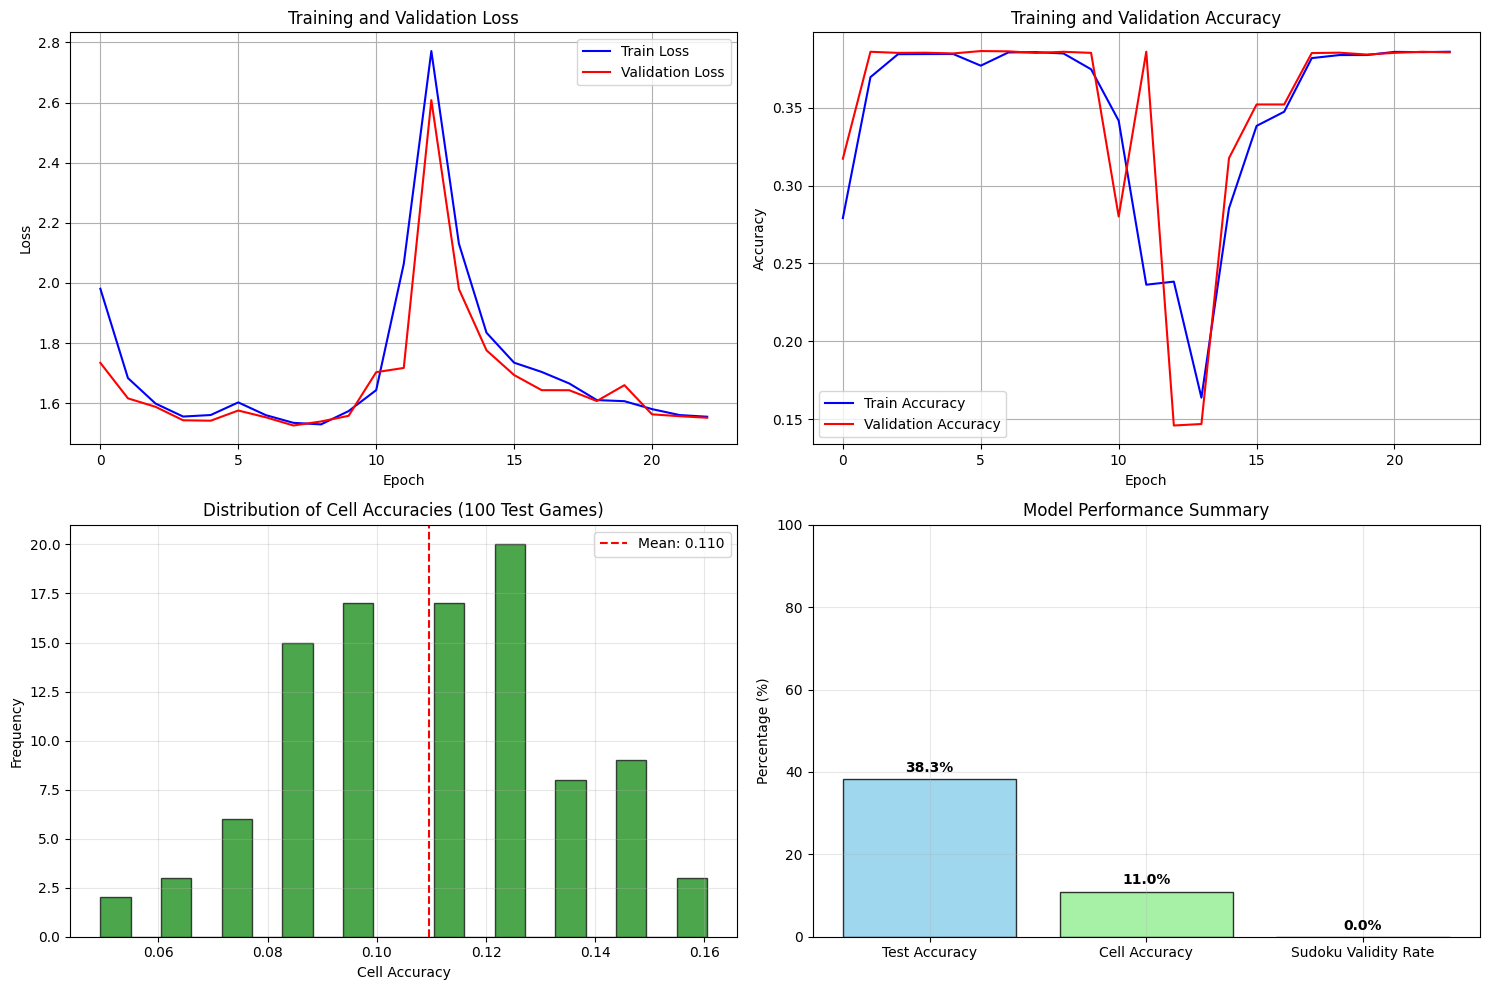

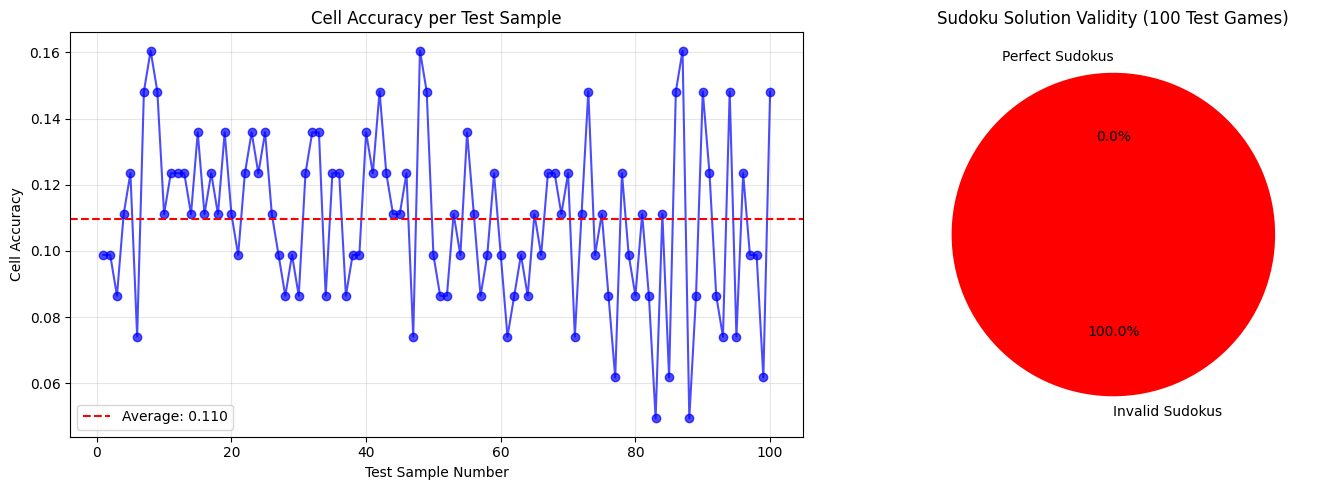


Graphs saved to 'results/model_evaluation_results.png' and 'results/detailed_accuracy_analysis.png'


In [10]:
# Load the best model and evaluate on 100 test samples
best_checkpoint = torch.load('results/best_model.pt', map_location=device)
#model.load_state_dict(best_checkpoint['model'])
print(f"Loaded best model from epoch {best_checkpoint['epoch']} with val_loss {best_checkpoint['val_loss']:.4f}")

# Create a subset of test dataset with 100 samples
test_subset_puzzles = test_puzzles[:100]
test_subset_solutions = test_solutions[:100]
test_subset_dataset = sudoku.SudokuDataset(test_subset_puzzles, test_subset_solutions)

# Comprehensive evaluation
print("\n=== Comprehensive Model Evaluation on 100 Test Games ===")

# 1. Basic accuracy evaluation using trainer
test_loss, test_acc = trainer.evaluate(test_subset_dataset)

# 2. Detailed Sudoku validation
detailed_results = validate_sudoku_predictions(model, test_subset_dataset, num_samples=100)

# 3. Summary statistics
print(f"\n=== Final Results Summary ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Valid Sudoku Solutions: {detailed_results['valid_sudokus']}/100 ({detailed_results['sudoku_validity_rate']*100:.2f}%)")
print(f"Average Cell Accuracy: {detailed_results['average_cell_accuracy']:.4f} ({detailed_results['average_cell_accuracy']*100:.2f}%)")

# 4. Visualizations
import matplotlib.pyplot as plt

# Create a comprehensive results visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Training curves
ax1.plot(trainer.train_losses, label='Train Loss', color='blue')
ax1.plot(trainer.val_losses, label='Validation Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(trainer.train_accuracies, label='Train Accuracy', color='blue')
ax2.plot(trainer.val_accuracies, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

# Cell accuracy distribution
ax3.hist(detailed_results['cell_accuracies'], bins=20, alpha=0.7, color='green', edgecolor='black')
ax3.set_xlabel('Cell Accuracy')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Cell Accuracies (100 Test Games)')
ax3.axvline(detailed_results['average_cell_accuracy'], color='red', linestyle='--', 
           label=f'Mean: {detailed_results["average_cell_accuracy"]:.3f}')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Summary metrics bar chart
metrics = ['Test Accuracy', 'Cell Accuracy', 'Sudoku Validity Rate']
values = [test_acc * 100, detailed_results['average_cell_accuracy'] * 100, 
          detailed_results['sudoku_validity_rate'] * 100]
colors = ['skyblue', 'lightgreen', 'lightcoral']

bars = ax4.bar(metrics, values, color=colors, edgecolor='black', alpha=0.8)
ax4.set_ylabel('Percentage (%)')
ax4.set_title('Model Performance Summary')
ax4.set_ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/model_evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional detailed accuracy analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Cell accuracy vs sample number
sample_numbers = range(1, len(detailed_results['cell_accuracies']) + 1)
ax1.plot(sample_numbers, detailed_results['cell_accuracies'], 'o-', alpha=0.7, color='blue')
ax1.axhline(detailed_results['average_cell_accuracy'], color='red', linestyle='--', 
           label=f'Average: {detailed_results["average_cell_accuracy"]:.3f}')
ax1.set_xlabel('Test Sample Number')
ax1.set_ylabel('Cell Accuracy')
ax1.set_title('Cell Accuracy per Test Sample')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Performance comparison chart
categories = ['Perfect Sudokus', 'Invalid Sudokus']
counts = [detailed_results['valid_sudokus'], 100 - detailed_results['valid_sudokus']]
colors = ['green', 'red']

ax2.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_title('Sudoku Solution Validity (100 Test Games)')

plt.tight_layout()
plt.savefig('results/detailed_accuracy_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGraphs saved to 'results/model_evaluation_results.png' and 'results/detailed_accuracy_analysis.png'")